# Week 9 - Beyond Text

This week, we "trascend" text to explore analysis of sound and visual content. Trillions of digital audio, image, and video files have been generated by cell phones and distributed sensors, preserved and shared through social medial, the web, private and government administrations. In this notebook, we read in and visualize audio and image files, process them to extract relevant features and measurement, then begin to explore how to analyze and extract information from them through the same approaches to supervised and unsupervised learning we have performed thoughout the quarter with text.

For this notebook we will use the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import scipy #For frequency analysis
import scipy.fftpack
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import IPython #To show stuff

#Image handling install as Pillow
import PIL
import PIL.ImageOps

#install as scikit-image, this does the image manupulation
import skimage
import skimage.feature
import skimage.segmentation
import skimage.filters
import skimage.color
import skimage.graph
import skimage.future.graph

#these three do audio handling
import pydub #Requires ffmpeg to be installed https://www.ffmpeg.org/download.html; on a mac "brew install ffmpeg"
import speech_recognition #install as speechrecognition
import soundfile #Install as pysoundfile 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning it may generate.
%matplotlib inline

import os
import os.path
import csv
import re

# Audio analysis 

First we will consider media that predates written language...sound and spoken language. Audio (and video) files come in two major categories, lossy or lossless. Lossless files save all information the microphone recorded. Lossy files, by contrast, drop sections humans are unlikely to notice. Recorded frequencies for both types are then typically compressed, which introduces further loss. To work with audio files, we want a format that is preferably lossless or minimally compressed. We will work with `wav` files here. Note that `mp3` is not acceptable. If you do not have `wav` files, we can use python to convert to `wav`.

You might need to install ```ffmpeg``` and ```ffprobe```.

In [14]:
samplePath = '../data/audio_samples/SBC060.mp3'
transcriptPath = '../data/audio_samples/SBC060.trn'

#IPython.display.Audio(samplePath)

In [15]:
# We are using a different package to convert than the in the rest of the code
def convertToWAV(sourceFile, outputFile, overwrite = False):
    if os.path.isfile(outputFile) and not overwrite:
        print("{} exists already".format(outputFile))
        return
    #Naive format extraction
    sourceFormat = sourceFile.split('.')[-1]
    sound = pydub.AudioSegment.from_file(sourceFile, format=sourceFormat)
    sound.export(outputFile, format="wav")
    print("{} created".format(outputFile))
wavPath = 'sample.wav'
convertToWAV(samplePath, wavPath)

sample.wav exists already


Now that we have created our `wav` file, notice that it is much larger than the source `mp3`. We can load it with `soundfile` and work with it as a numpy data array.

In [16]:
soundArr, soundSampleRate = soundfile.read(wavPath)
soundArr.shape

(65705472, 2)

This is the raw data as a column array, which contains two channels (Left and Right) of the recording device. Some files, of course, will have more columns (from more microphones). The array comprises a series of numbers that measure the location of the speaker membrane (0=resting location). By quickly and rhythmically changing the location a note can be achieved. The larger the variation from the center, the louder the sound; the faster the oscillations, the higher the pitch. (The center of the oscillations does not have to be 0).

In [17]:
soundSampleRate

44100

The other piece of information we get is the sample rate. This tells us how many measurements made per second, which allows us to know how long the entire recording is:

In [18]:
numS = soundArr.shape[0] // soundSampleRate
print("The sample is {} seconds long".format(numS))
print("Or {:.2f} minutes".format(numS / 60))

The sample is 1489 seconds long
Or 24.82 minutes


The final critical parameter of sound digitization is quantisation, which consists in assigning a value to each sample according to its amplitude. These values are attributed according to a bit scale. A quantisation of 8 bit will assign amplitude values along a scale of $2^8 = 256$ states around 0. Most recording systems use a $2^{16} = 65536$ bit system. Quantisation is a rounding process, where high bit quantisation produces values close to reality with values rounded to a high number of significant digits, and low bit quantisation produces values further from reality with values rounded a low number of significants digits. Low quantisation can lead to impaired quality signal. <img src="../data/bitrate.png"> This figure illustrates how digital sounds is a discrete process along the amplitude scale: a 3 bit, $2^3=8$, quantization (gray bars) gives a rough approximation of the sin wave (red line).

Let's look at the first second of the recording:

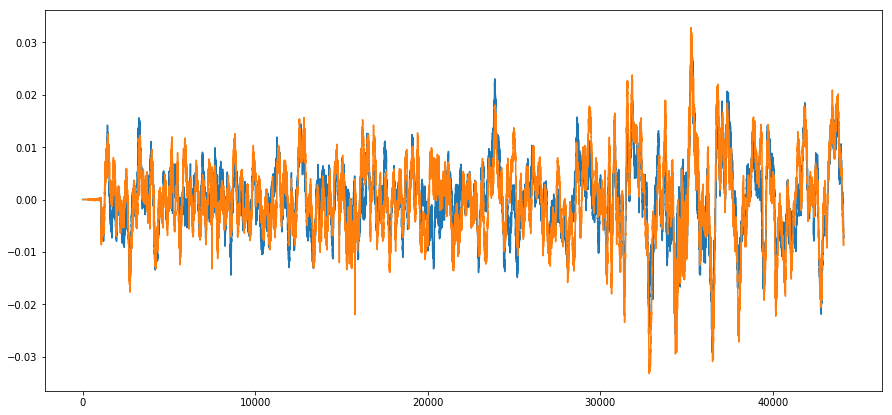

In [19]:
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(soundArr[:soundSampleRate])
plt.show()

We get 2 (Left and Right) nearly "flat" (or equally wavy) lines. This means that there is very little noise at this part of the recording. What variation exists is due to compression or interference and represents the slight hiss you sometimes hear in low quality recordings.

Let's expand our scope and look at the first 10 seconds:

In [20]:
soundArr.shape

(65705472, 2)

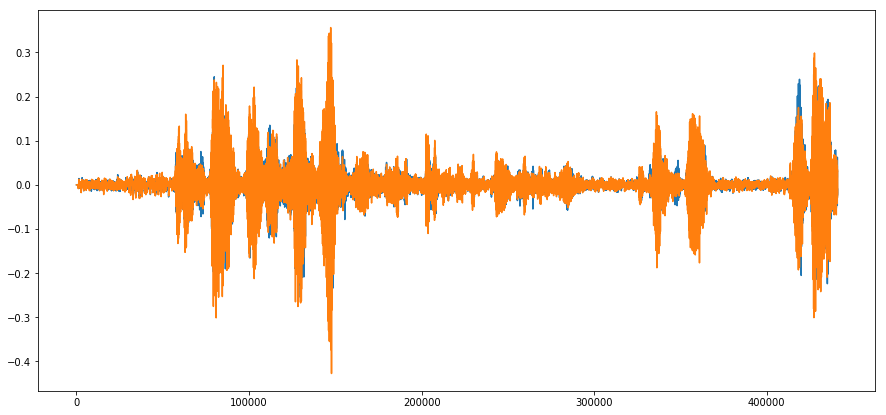

In [21]:
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(soundArr[:soundSampleRate * 10])
plt.show()

Now we can see definite spikes, where each represents a word or discrete sound.

To see what the different parts correspond to, we can use a transcript. Because we got this file from the [Santa Barbara Corpus of Spoken American English
](http://www.linguistics.ucsb.edu/research/santa-barbara-corpus#Contents), we just need to load the metadata, which includes a transcription.

In [22]:
def loadTranscript(targetFile):
    #Regex because the transcripts aren't consistent enough to use csv
    regex = re.compile(r"(\d+\.\d+)\s(\d+\.\d+)\s(.+:)?\s+(.*)")
    dfDict = {
        'time_start' : [],
        'time_end' : [],
        'speaker' : [],
        'text' : [],
    }
    with open(targetFile, encoding='latin-1') as f:
        for line in f:
            r = re.match(regex, line)
            dfDict['time_start'].append(float(r.group(1)))
            dfDict['time_end'].append(float(r.group(2)))
            if r.group(3) is None:
                dfDict['speaker'].append(dfDict['speaker'][-1])
            else:
                dfDict['speaker'].append(r.group(3))
            dfDict['text'].append(r.group(4))
    return pandas.DataFrame(dfDict)

transcriptDF = loadTranscript(transcriptPath)
transcriptDF[:10]

,time_start,time_end,speaker,text
0,0.000,2.572,ALAN:,"... (H) I got a story to tell you,"
1,2.572,3.820,ALAN:,"it's a shaggy dog story,"
2,3.820,6.645,ALAN:,but as long as were talking about that record...
3,6.645,8.378,ALAN:,"(H)= Ill tell you the story,"
4,8.378,10.178,ALAN:,"(H)= oh gosh,"
5,10.178,10.678,ALAN:,"uh (Hx),"
6,10.678,12.335,ALAN:,"Rae and I and Sue and Buddy,"
7,12.335,14.727,ALAN:,"... took a trip,"
8,14.727,17.012,ALAN:,"... to Mexico City,"
9,17.012,18.761,JON:,... (SNIFF)


Now let's look at a few sub-sections. First, to make things easier, we will convert the seconds markers to sample indices:

In [23]:
#Need to be ints for indexing, luckily being off by a couple indices doesn't matter
transcriptDF['index_start'] = (transcriptDF['time_start'] * soundSampleRate).astype('int')
transcriptDF['index_end'] = (transcriptDF['time_end'] * soundSampleRate).astype('int')

In [27]:
transcriptDF[:10]

,time_start,time_end,speaker,text,index_start,index_end
0,0.000,2.572,ALAN:,"... (H) I got a story to tell you,",0,113425
1,2.572,3.820,ALAN:,"it's a shaggy dog story,",113425,168462
2,3.820,6.645,ALAN:,but as long as were talking about that record...,168462,293044
3,6.645,8.378,ALAN:,"(H)= Ill tell you the story,",293044,369469
4,8.378,10.178,ALAN:,"(H)= oh gosh,",369469,448849
5,10.178,10.678,ALAN:,"uh (Hx),",448849,470899
6,10.678,12.335,ALAN:,"Rae and I and Sue and Buddy,",470899,543973
7,12.335,14.727,ALAN:,"... took a trip,",543973,649460
8,14.727,17.012,ALAN:,"... to Mexico City,",649460,750229
9,17.012,18.761,JON:,... (SNIFF),750229,827360


Lets see what `'Rae and I and Sue and Buddy,'` looks like, which is the seventh row:

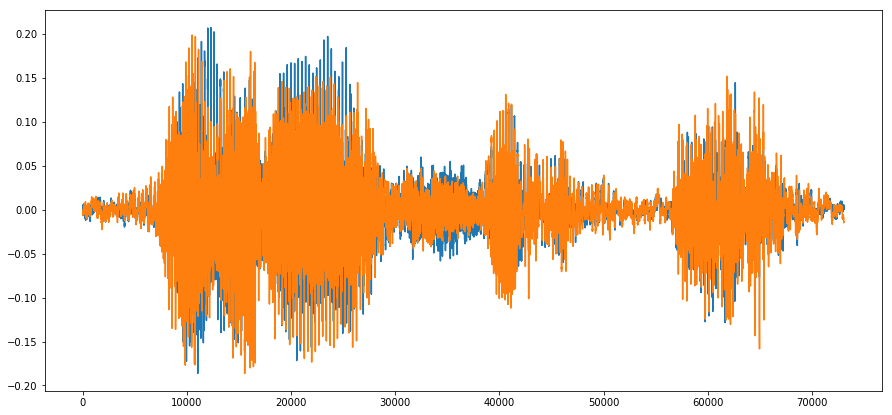

In [28]:
fig, ax = plt.subplots(figsize = (15, 7))
subSample1 = soundArr[transcriptDF['index_start'][6]: transcriptDF['index_end'][6]]
ax.plot(subSample1)
plt.show()

And now let's hear what that sounds like:

In [38]:
soundfile.write('../data/audio_samples/sample1.wav', subSample1, soundSampleRate)
IPython.display.Audio('../data/audio_samples/sample1.wav')

In order to see sounds in the frequency space, we can take the Fourier transform. This is a reversible mathematical transform named after the French mathematician Joseph Fourier (1768-1830) <img src="data/Fourier.jpg">. The transform decomposes a time series into a sum of finite series of sine or cosine functions.

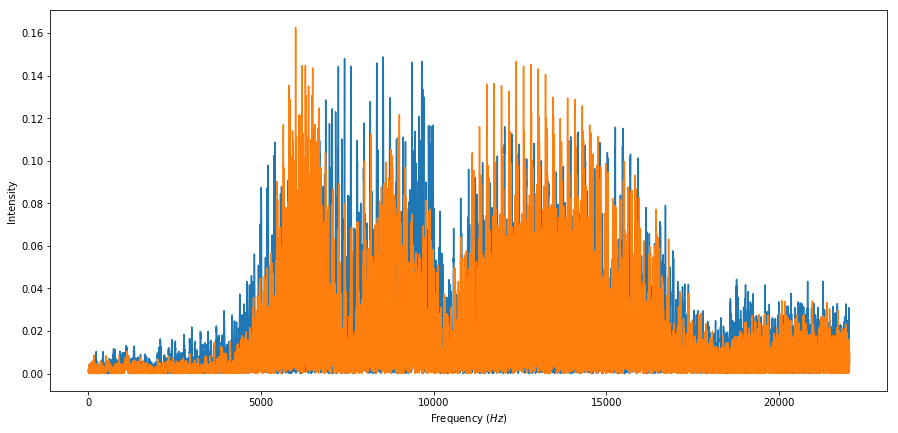

In [29]:
sample1FFT = scipy.fftpack.ifft(subSample1)
N = len(sample1FFT)
freq = scipy.fftpack.fftfreq(N, d = 1 / soundSampleRate)
fig, ax = plt.subplots(figsize = (15, 7))
ax.set_xlabel('Frequency ($Hz$)')
ax.set_ylabel('Intensity')
ax.plot(freq[:N//2], abs(sample1FFT)[:N//2]) #Only want positive frequencies
plt.show()

This shows that there are two frequencies to the 'Rae and I and Sue and Buddy' snippet: a higher pitched 'Rae and I...Sue...Buddy' (~14000 *Hz*) and the final two 'and's (one at ~6000 *Hz* and the second at ~8000 *Hz*).

What does a sniff look like?

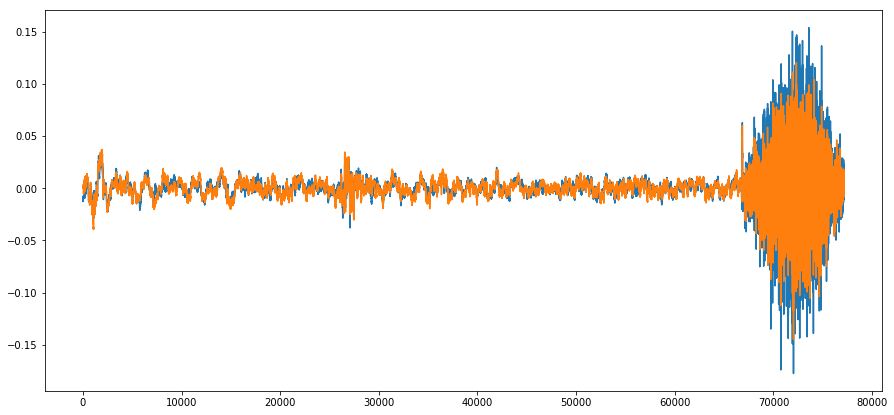

In [30]:
fig, ax = plt.subplots(figsize = (15, 7))
subSample2 = soundArr[transcriptDF['index_start'][9]: transcriptDF['index_end'][9]]
ax.plot(subSample2)
plt.show()

Very different from speech. And now let's see what that sounds like:

In [ ]:
soundfile.write('../data/audio_samples/sample2.wav', subSample2, soundSampleRate)
IPython.display.Audio('../data/audio_samples/sample2.wav')

and in frequency space:

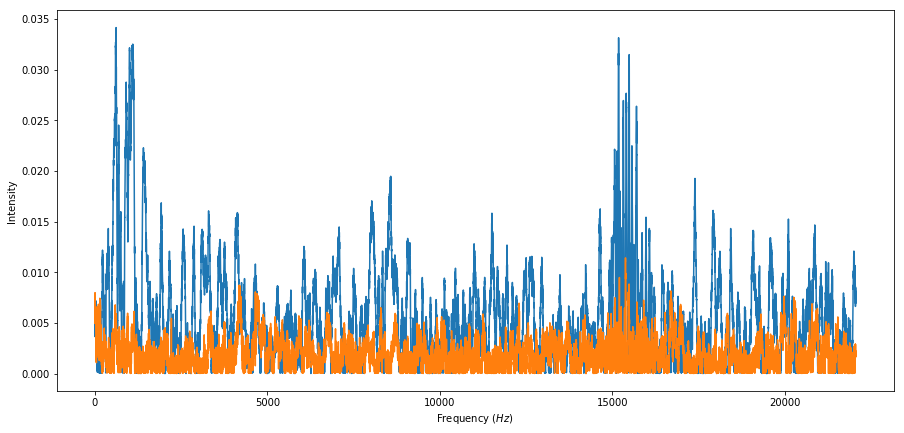

In [31]:
sample2FFT = scipy.fftpack.ifft(subSample2)
N = len(sample2FFT)
freq = scipy.fftpack.fftfreq(N, d = 1 / soundSampleRate)
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(freq[:N//2], abs(sample2FFT)[:N//2]) #Only want positive frequencies
ax.set_xlabel('Frequency ($Hz$)')
ax.set_ylabel('Intensity')
plt.show()

Notice how there is not a dominant frequency for the sniff as there was for the noun phrase earlier. This means that the sniff activated noise all across the frequency spectrum.

We can also investigate dominant frequencies for the entire record:

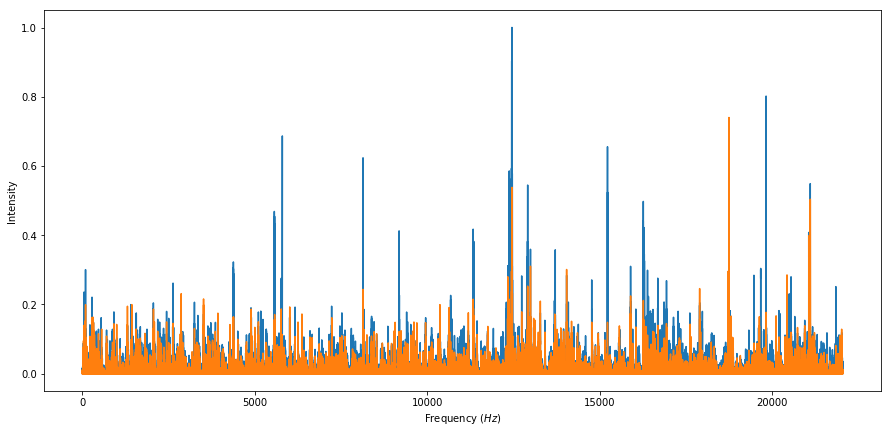

In [32]:
#This takes a while
fig, ax = plt.subplots(figsize = (15, 7))
fullFFT = scipy.fftpack.ifft(soundArr)
N = len(fullFFT)
freq = scipy.fftpack.fftfreq(N, d = 1 / soundSampleRate)
ax.plot(freq[:N//2], abs(fullFFT)[:N//2]) #Only want positive frequencies
ax.set_xlabel('Frequency ($Hz$)')
ax.set_ylabel('Intensity')
plt.show()

In [33]:
freq[len(freq) // 2 -10: len(freq) // 2 + 5]

array([ 22049.99328823,  22049.99395941,  22049.99463058,  22049.99530176,
        22049.99597294,  22049.99664412,  22049.99731529,  22049.99798647,
        22049.99865765,  22049.99932882, -22050.        , -22049.99932882,
       -22049.99865765, -22049.99798647, -22049.99731529])

Here we capture each person's frequencies across their entire collection of statements:

In [34]:
def maxfreq(sample, topN = 10):
    sampleFFT = scipy.fftpack.ifft(sample)
    N = len(sample)
    freqs = scipy.fftpack.fftfreq(N, d = 1 / soundSampleRate)
    tops =  np.argpartition(abs(sampleFFT[:, 0]), -topN)[-topN:]

    return np.mean(tops) 

freqs = []
for i, row in transcriptDF.iterrows():
    freqs.append(maxfreq(soundArr[row['index_start']: row['index_end']]))

transcriptDF['frequency FFT'] = freqs

Alan's speech exhibits the following frequencies:

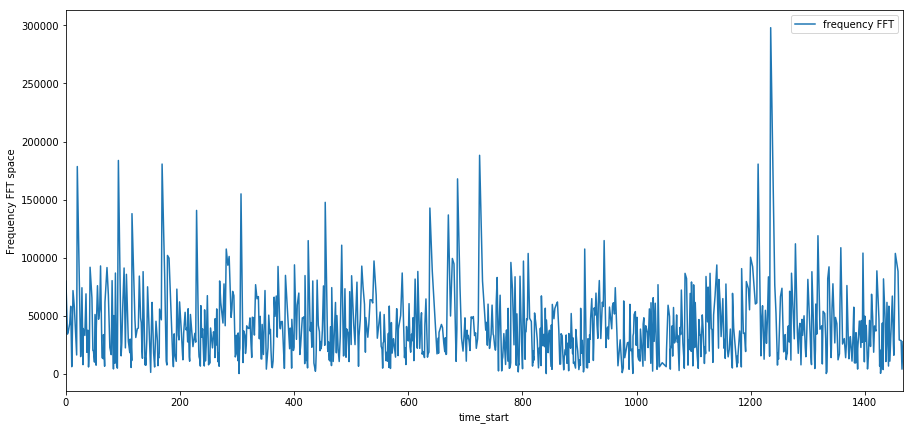

In [35]:
fig, ax = plt.subplots(figsize = (15, 7))
transcriptDF[transcriptDF['speaker'] == 'ALAN:'].plot( 'time_start', 'frequency FFT', ax = ax)
ax.set_ylabel("Frequency FFT space")
plt.show()

...while Jon's voice is **much** lower:

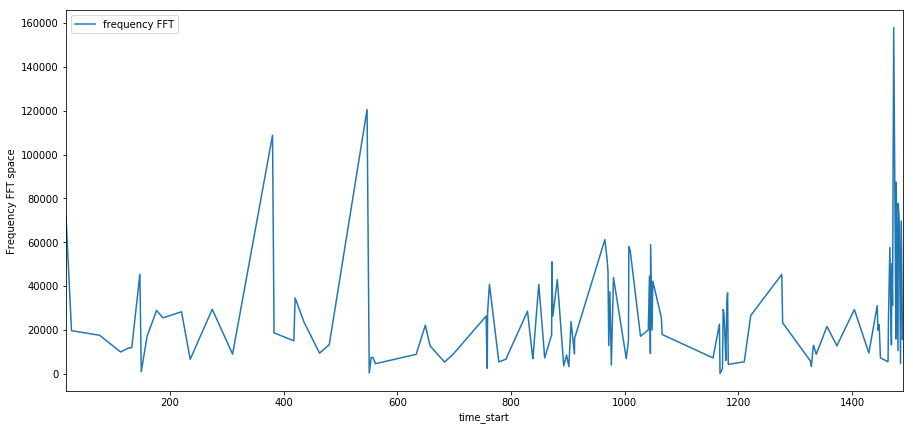

In [36]:
fig, ax = plt.subplots(figsize = (15, 7))
transcriptDF[transcriptDF['speaker'] == 'JON:'].plot( 'time_start', 'frequency FFT', ax = ax)
ax.set_ylabel("Frequency FFT space")
plt.show()

Or we can look at them togther

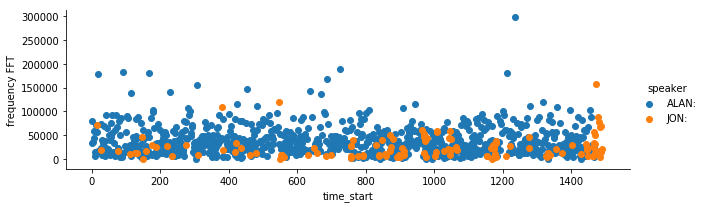

In [37]:
fg = seaborn.FacetGrid(data=transcriptDF, hue='speaker', aspect = 3)
fg.map(plt.scatter, 'time_start', 'frequency FFT').add_legend()

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that read in 10 audio files (e.g., produced on your smartphone recorder?) from at least two different speakers, which include sentences of different types (e.g., question, statement, exclamation). At least two of these should include recordings of the two speakers talking to each other (e.g., a simple question/answer). Contrast the frequency distributions of the words spoken within speaker. What speaker's voice has a higher and which has lower frequency? What words are spoken at the highest and lowest frequencies? What parts-of-speech tend to be high or low? How do different types of sentences vary in their frequency differently? When people are speaking to each other, how do their frequencies change? Whose changes more?

## Speech-to-Text

We can also do speech recognition on audio, but this requires a complex machine learning system. Luckily there are many online services to do this. We have a function that uses Google's API. There are two API's: one is free but limited; the other is commercial and you can provide the function `speechRec` with a file containing the API keys, using `jsonFile=` if you wish. For more about this look [here](https://stackoverflow.com/questions/38703853/how-to-use-google-speech-recognition-api-in-python) or the `speech_recognition` [docs](https://github.com/Uberi/speech_recognition).

In [7]:
#Using another library so we need to use files again
def speechRec(targetFile, language = "en-US", raw = False, jsonFile = ''):
    r = speech_recognition.Recognizer()
    if not os.path.isfile(jsonFile):
        jsonString = None
    else:
        with open(jsonFile) as f:
            jsonString = f.read()
    with speech_recognition.AudioFile(targetFile) as source:
        audio = r.record(source)
    try:
        if jsonString is None:
            print("Sending data to Google Speech Recognition")
            dat =  r.recognize_google(audio)
        else:
            print("Sending data to Google Cloud Speech")
            dat =  r.recognize_google_cloud(audio, credentials_json=jsonString)
    except speech_recognition.UnknownValueError:
        print("Google could not understand audio")
    except speech_recognition.RequestError as e:
        print("Could not request results from Google service; {0}".format(e))
    else:
        print("Success")
        return dat

The example above is of too low quality so we will be using another file `data/audio_samples/english.wav`

In [ ]:
import wave

# open up a wave
wf = wave.open('../data/audio_samples/english.wav', 'rb')
swidth = wf.getsampwidth()
RATE = wf.getframerate()

In [ ]:
IPython.display.Audio('../data/audio_samples/english.wav', rate=RATE)

In [ ]:
speechRec('../data/audio_samples/english.wav')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that use the 10 audio files from at least two different speakers read in previously, attempt to automatically extract the words from Google, and calculate the word-error rate, as descibed in Chapter 9 from *Jurafsky & Martin*, page 334. How well does it do? Under what circumstances does it perform poorly? 

In [4]:
DD_weeknd = 'DD.mp3'
DD_weekndWav = 'DD.wav'
convertToWAV(DD_weeknd, DD_weekndWav)

DD.wav exists already


In [5]:
import wave

# open up a wave
wf = wave.open(DD_weekndWav, 'rb')
swidth = wf.getsampwidth()
RATE = wf.getframerate()

In [ ]:
IPython.display.Audio(DD_weekndWav, rate=RATE)

In [8]:
speechRec(DD_weekndWav)

Sending data to Google Speech Recognition
Could not request results from Google service; recognition connection failed: [Errno 32] Broken pipe


# Image analysis

Now we will explore image files. First, we will read in a couple of images. Please change the working image and see how the resuts differ:

In [ ]:
image_wiki = PIL.Image.open('../data/IMAGES/Wikimedia_Conference_2016_–_Group_photo.jpg')
image_wikiGray = PIL.ImageOps.invert(image_wiki.convert('L'))

image_AllSaints = PIL.Image.open('../data/IMAGES/AllSaintsMargaretStreet-DAVID_ILIFF.jpg')
image_AllSaintsGray = PIL.ImageOps.invert(image_AllSaints.convert('L'))

image_Soyuz = PIL.Image.open('../data/IMAGES/Soyuz.jpg')
image_SoyuzGray = PIL.ImageOps.invert(image_Soyuz.convert('L'))

image_Rock = PIL.Image.open('../data/IMAGES/Bi-crystal.jpg')
image_RockGray = PIL.ImageOps.invert(image_Rock.convert('L'))

image_flowers = PIL.Image.open('../data/IMAGES/flowers.jpg')
image_flowersGray = PIL.ImageOps.invert(image_flowers.convert('L'))

image = image_flowers

image

In [ ]:
imageArr = np.asarray(image)
imageArr.shape

The image we have loaded is a raster image, meaning it is a grid of pixels. Each pixel contains 1-4 numbers giving the amounts of color contained in it. In this case, we can see it has 3 values per pixel, these are RGB or Red, Green and Blue values. If we want to see just the red, we can look at just that array:

In [ ]:
imgRatio = imageArr.shape[0] / imageArr.shape[1]
fig, ax = plt.subplots(figsize = (15, 15))
ax.imshow(imageArr[:,:,0], cmap='Reds') #The order is R G B, so 0 is the Reds
ax.axis('off')
plt.show()

Or the others:

In [ ]:
imgRatio = imageArr.shape[0] / imageArr.shape[1]
fig, ax = plt.subplots(figsize = (15, 15))
ax.imshow(imageArr[:,:,1], cmap='Greens') #The order is R G B, so 2 is the Green
ax.axis('off')
plt.show()

In [ ]:
imgRatio = imageArr.shape[0] / imageArr.shape[1]
fig, ax = plt.subplots(figsize = (15, 15))
ax.imshow(imageArr[:,:,2], cmap='Blues') #The order is R G B, so 2 is the Blue
ax.axis('off')
plt.show()

Or we can look at all four together:

In [ ]:
fig, axes = plt.subplots(figsize = (10, 10), ncols=2, nrows=2)
axeIter = iter(axes.flatten())
colours = ["Reds", "Greens", "Blues"]
ax = next(axeIter)
ax.imshow(imageArr)
ax.axis('off')

for i in range(3):
    ax = next(axeIter)
    ax.imshow(imageArr[:,:,i], cmap=colours[i]) #The order is R G B, so 2 is the Blue
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
image_gray = PIL.ImageOps.invert(image.convert('L'))
image_grayArr = np.asarray(image_gray)
image_grayArr.shape

A grayscale image is defined by its pixel intensities (and a color image can be defined by its red, green, blue pixel intensities).

In [ ]:
imgRatio = imageArr.shape[0] / imageArr.shape[1]
fig, ax = plt.subplots(figsize = (15, 15))
ax.imshow(image_grayArr) #No third dimension
ax.axis('off')
plt.show()

## Blob Detection

Recall our earlier use of scikit-learn for machine learning. Now we will use scikit-image to do some simple image processing. Here we will perform three operations for 'blob' of simple object detection. In computer vision, blob detection methods aim to detect regions in a digital image that differ in properties, such as brightness or color, compared to surrounding regions. Informally, a blob is a region of an image in which some properties are approximately constant or similar to each other. We will do this in three ways.

First, we will take the Laplacian of an image, which is a 2-D isotropic (applying equally well in all directions) measure of the 2nd spatial derivative of an image. The Laplacian of an image highlights regions of rapid intensity change and is therefore often used for edge detection. This Laplacian is taken of the image once a Gaussian smoothing filter has been applied in order to reduce its sensitivity to noise.

The Laplacian $L(x,y)$ of an image with pixel intensity values $I(x,y)$ is given by: $L(x,y)=\frac{\delta^2x}{\delta x^2} + \frac{\delta^2y}{\delta y^2}$. A Gaussian smoothing filter takes a 2 dimensional Guassian, $G(x,y)=\frac{1}{2 \pi \sigma^2} e^\frac{-x^2 + y^2}{2\sigma^2}$, which looks like: <img src="http://www.librow.com/content/common/images/articles/article-9/2d_distribution.gif">

This Gaussian *kernel* is applied to the pixel intensities of the image via *convolution* -- the kernel is multiplied by the pixel intensities, while centered on each pixel, then added.

The blob detector computes the [Laplacian of Gaussian (LoG)](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log) images with successively increasing standard deviation and stacks them up in a cube. Blobs are local maximas within this cube. Detecting larger blobs is slower because of larger kernel sizes during convolution. Bright blobs on dark backgrounds are detected.

In [ ]:
blobs_log = skimage.feature.blob_log(image_grayArr, max_sigma=30, num_sigma=5, threshold=.1)
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2) #Radi
fig, ax = plt.subplots(figsize = (15, 15))
ax.axis('off')

plt.imshow(image_grayArr, interpolation='nearest')
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, linewidth=2, fill=False)
    ax.add_patch(c)

Second, we look at [Difference of Gaussian (DoG)](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_dog), a much faster approximation of the LoG approach in which an image is blurred with increasing standard deviations and the difference between two successively blurred images are stacked up in a cube. 

In [ ]:
blobs_dog = skimage.feature.blob_dog(image_grayArr, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)
fig, ax = plt.subplots(figsize = (15, 15))
ax.axis('off')

plt.imshow(image_grayArr, interpolation='nearest')
for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r, linewidth=2, fill=False)
    ax.add_patch(c)

Finally, we consider the [Determinant of Hessian (DoH)](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_doh) approach. The Hessian matrix or Hessian is a square matrix of second-order partial derivatives $\frac{\partial^2 f}{\partial x_i \partial x_j}(x_1^{*}, \ldots, x_n^{*})$ and is calculated on square pixel patches of the image. The determinant is the scaling factor of each patch. This approach is fastest and detects blobs by finding maximas in this matrix (of the Determinant of the Hessian of the image). Detection speed is independent of the size of blobs as the implementation uses box filters, $\begin{bmatrix}1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1\end{bmatrix}$, instead of Gaussians for the convolution. As a result, small blobs (< 3 pixels) cannot be detected accurately. 

In [ ]:
blobs_doh = skimage.feature.blob_doh(image_grayArr, max_sigma=30, threshold=.01)
fig, ax = plt.subplots(figsize = (15, 15))
ax.axis('off')

plt.imshow(image_grayArr, interpolation='nearest')
for blob in blobs_doh:
    y, x, r = blob
    c = plt.Circle((x, y), r, linewidth=2, fill=False)
    ax.add_patch(c)

Humans possess an incredible ability to identify objects in an image. Segmentation is the process of dividing an image into meaningful regions. All pixels belonging to a region should receive a unique label in an ideal segmentation.

Region Adjacency Graphs (RAGs) are a common data structure for many segmentation algorithms. First, we define regions through the SLIC algorithm that assigns a unique label to each region or a localized cluster of pixels sharing some similar property (e.g., color or grayscale intensity). Then we'll consider each region a node in a graph, and construct a region boundary RAG, where the edge weight between two regions is the average value of the corresponding pixels in edge_map along their shared boundary. Then edges below a specified threshold are removed and a connected component is labeled as one region. 

NOTE: A change to networkx means the following code might not work on your laptop.

In [ ]:
# labels = skimage.segmentation.slic(image_grayArr, compactness=30, n_segments=400)
# g = skimage.graph.rag_mean_color(image_grayArr, labels)
# fig, ax = plt.subplots(figsize = (15, 15))
# ax.axis('off')
# lc = skimage.future.graph.show_rag(labels, g, image_grayArr, ax = ax)

Interesting boundaries were constructed for this image.

We can generalize many of the approaches into a collection of kernel methods. These are also how Convolutional Neural Networks (CNNs) create their features:

In [ ]:
def normalizeConvo(a_c):
    s = np.sum(a_c.flatten())
    return a_c / s

def displayConvolution(img, convArray, threshold = None):
    img_array = np.asarray(img).astype('uint8')
    
    if len(img_array.shape) > 2:
        conv = np.zeros(img_array.shape)
        for i in range(img_array.shape[2]):
            conv[:,:,i] = scipy.ndimage.convolve(img_array[:,:,i], normalizeConvo(convArray), mode='constant')
    else:
        conv = scipy.ndimage.convolve(img_array, normalizeConvo(convArray), mode='constant')
    conv = conv.astype('uint8')
    if threshold is not None:
        if threshold < 1:
            threshold = threshold * 255
        conv[conv < threshold] = 0
    
    conv_image = PIL.Image.fromarray(conv)
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (17, 10))
    #This is to deal with some annoying plt/PIL stuff
    if len(img_array.shape) > 2:
        ax1.imshow(img)
    else:
        ax1.imshow(img_array)
    ax1.axis('off')
    ax1.set_title("Original")
    #return conv_image
    if len(img_array.shape) > 2:
        ax2.imshow(conv_image)
    else:
        ax2.imshow(np.asarray(conv_image))
    ax2.axis('off')
    ax2.set_title("Convolution")
    
    diff = PIL.ImageChops.difference(conv_image, img)
    if len(img_array.shape) > 2:
        ax3.imshow(diff)
    else:
        ax3.imshow(np.asarray(diff))
    ax3.axis('off')
    ax3.set_title("Difference")
    plt.tight_layout()
    plt.show()
    #Not returning anything to make displaying nicer

[Here](https://en.wikipedia.org/wiki/Kernel_(image_processing%29) are a fistfull kenels to try. In image processing, kernels (also convolution matrices or masks) are small matrices. They are used for blurring, sharpening, edge detection, and more. This is accomplished by doing a convolution between a kernel and an image by adding each element of the image to its local neighbors, weighted by the kernel, as shown below:

In [ ]:
smoothingKernel = np.array([
    [1, 1, 1],
    [1, 2, 1],
    [1, 1, 1]])
c = displayConvolution(image_gray, smoothingKernel)

In [ ]:
verticalLineKernel = np.array([
    [1, 0, -1],
    [0, 8, 0],
    [1, 0, -1]])
displayConvolution(image, verticalLineKernel, threshold=.6)

In [ ]:
diagonalLineKernel = np.array([
    [-1, 0, -1],
    [0, 8, 0],
    [1, 0, -1]])
displayConvolution(image, diagonalLineKernel, threshold=.6)

In [ ]:
blurKernel = np.array([
    [1, 2, 4, 2, 1],
    [2, 4, 8, 4, 2],
    [4, 8, 16, 8, 4],
    [2, 4, 8, 4, 2],
    [1, 2, 4, 2, 1]])
displayConvolution(image, blurKernel)

In [ ]:
SharpenKernel = np.array([
    [ 0,  0,  -1,  0,  0],
    [ 0, -1,  -2, -1,  0],
    [-1, -2,  20, -2, -1],
    [ 0, -1,  -2, -1,  0],
    [ 0,  0,  -1,  0,  0]])
displayConvolution(image, SharpenKernel)

In [ ]:
differentKernel = np.array([
    [ 1, 0,  0, 0,  -1],
    [ 1, 0,  0, 0,  -1],
    [ 1, 0,  1, 0,  -1],
    [ 1, 0,  0, 0,  -1],
    [ 1, 0,  0, 0,  -1]])
#This looks neat
displayConvolution(image, differentKernel)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that read in 10 image files (e.g., produced on your smartphone, harvested from the web, etc.) that feature different kinds of objects and settings, including at least one indoor and one outdoor setting. Perform blob detection and RAG segmentation using the approaches modeled above. How well does each algorithm identify objects or features of interest?

# Deep Nets and Images

Modern image and video analysis is typically performed using deep learning implemented as layers of convolutional neural nets to classify scenes and to detect and label objects. To learn more about deep learning and convolutional neural networks, spend some time with Andrew Ng's excellent [tutorial](http://ufldl.stanford.edu/tutorial/). 

We saw how we can use PyTorch and Google Colab in last weeks homework. [This PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) demonstrates how to train the classifiers. Image captioning is another application of such deep neural nets - [this GitHub repository](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning) walks us through how to do image captioning with pytorch. Object Detection and Scene Classification are other ways deep neural nets are used for images - [this PyTorch tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) demonstrates Object Deteciton, and there are multiple ([1](https://github.com/buptchan/scene-classification), [2](https://github.com/ran337287/MRCNN-for-Scene-Classification), [3](https://github.com/zanilzanzan/FuseNet_PyTorch)]. Another popular open source image object detector is [UC Berkeley's caffe library](http://caffe.berkeleyvision.org) of trained and trainable neural nets written in C++. (Check out the [python api](https://github.com/BVLC/caffe/blob/master/python/caffe/pycaffe.py)). Scene classifiers can be built on top of caffe, such as MIT's [Places](http://places2.csail.mit.edu/demo.html). 



## <span style="color:red">*Exercise 4*</span>

<span style="color:red">You can either:
    
a) Construct cells immediately below this that report the results from experiments in which you place each of images taken or retrieved for the last exercise through the online demos for [caffe](http://demo.caffe.berkeleyvision.org) and [places](http://places.csail.mit.edu/demo.html). Paste the image and the output for both object detector and scene classifier below, beside one another. Calculate precision and recall for caffe's ability to detect objects of interest across your images. What do you think about Places' scene categories and their assignments to your images? 
    
b) Implement any one deep learning example using PyTorch and images.

Could you use image classification to enhance your research project and, if so, how?